In [165]:
###### Imports Section ######

# Linear algebra using numpy
import numpy as np 

# Data processing using pandas
import pandas as pd 

import os

from datetime import datetime, timedelta

from sklearn.model_selection import KFold, StratifiedKFold

from tensorflow.python.keras.models import load_model

# Scatterplots
import plotly.graph_objects as go

# Keras for deep learning
from tensorflow import keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RNN, Activation, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import Layer
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.python.keras import callbacks as callback
from tensorflow.python.keras import backend as K

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

# MinMaxScaler for transforming features by scaling each feature to a given range
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

# For reading Google Drive files
import requests

# String manipulation
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

# Data visualization libraries
import seaborn as sb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# sklearn models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

# Cross validation library
from sklearn.model_selection import cross_val_score

# Use the following for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Use the following two libraries for confusion matrices
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# The following library is used for classifiers precision
from sklearn.metrics import precision_score, recall_score

# The following library is used for precision recall curve
from sklearn.metrics import precision_recall_curve

# F-score library
from sklearn.metrics import f1_score

# ROC curve library
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ROC AUC score library
from sklearn.metrics import roc_auc_score

# Use defaultdict for running totals + frequencies
from collections import defaultdict

# Fix for Jupyter not displaying all of the results
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import the following to support regular expressions
import re

from bs4 import BeautifulSoup

sb.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 20, "axes.labelsize" : 10, 
            "xtick.labelsize" : 15, "ytick.labelsize" : 15 })

###### End Imports Section #######

In [64]:
# LSTM sequence
def to_sequence(data, seq_len):
    d = []
    for i in range(len(data) - seq_len):
        d.append(data[i: i + seq_len])
    return np.array(d)

# LSTM Preprocess
def preprocess(data_raw, seq_len, train_split):
    data = to_sequence(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    
    return X_train, y_train, X_test, y_test

# Get Model Name
def get_model_name(k):
    return 'model_'+str(k)+'.hdf5'

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [166]:
###### Data Section ######

# Get Bitcoin price data

file_BitcoinPrice ='https://drive.google.com/file/d/1ZO20Jko427imyxVkrtM6MMa8coLkwUSR/view?usp=sharing'

bitcoinPrice_file_id = file_BitcoinPrice.split('/')[-2]
downloadURL='https://drive.google.com/uc?export=download&id=' + bitcoinPrice_file_id
formattedURL = requests.get(downloadURL).text
csv = StringIO(formattedURL)
bitcoinPrice_df = pd.read_csv(csv, parse_dates=['Date'])
bitcoinPrice_df = bitcoinPrice_df.sort_values('Date')

# End get Bitcoin price data 

###### End Data Section ######

In [5]:
# Preliminary data exploration of Bitcoin price data
print('Preliminary data exploration of Bitcoin price dataframe')
bitcoinPrice_df.info()

Preliminary data exploration of Bitcoin price dataframe
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760 entries, 1759 to 0
Data columns (total 7 columns):
Date          1760 non-null datetime64[ns]
Open          1760 non-null float64
High          1760 non-null float64
Low           1760 non-null float64
Close         1760 non-null float64
Volume        1760 non-null object
Market Cap    1760 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 110.0+ KB


In [170]:
# Resample to monthly frequency
btc = bitcoinPrice_df
btc_month = btc.resample('M').mean()

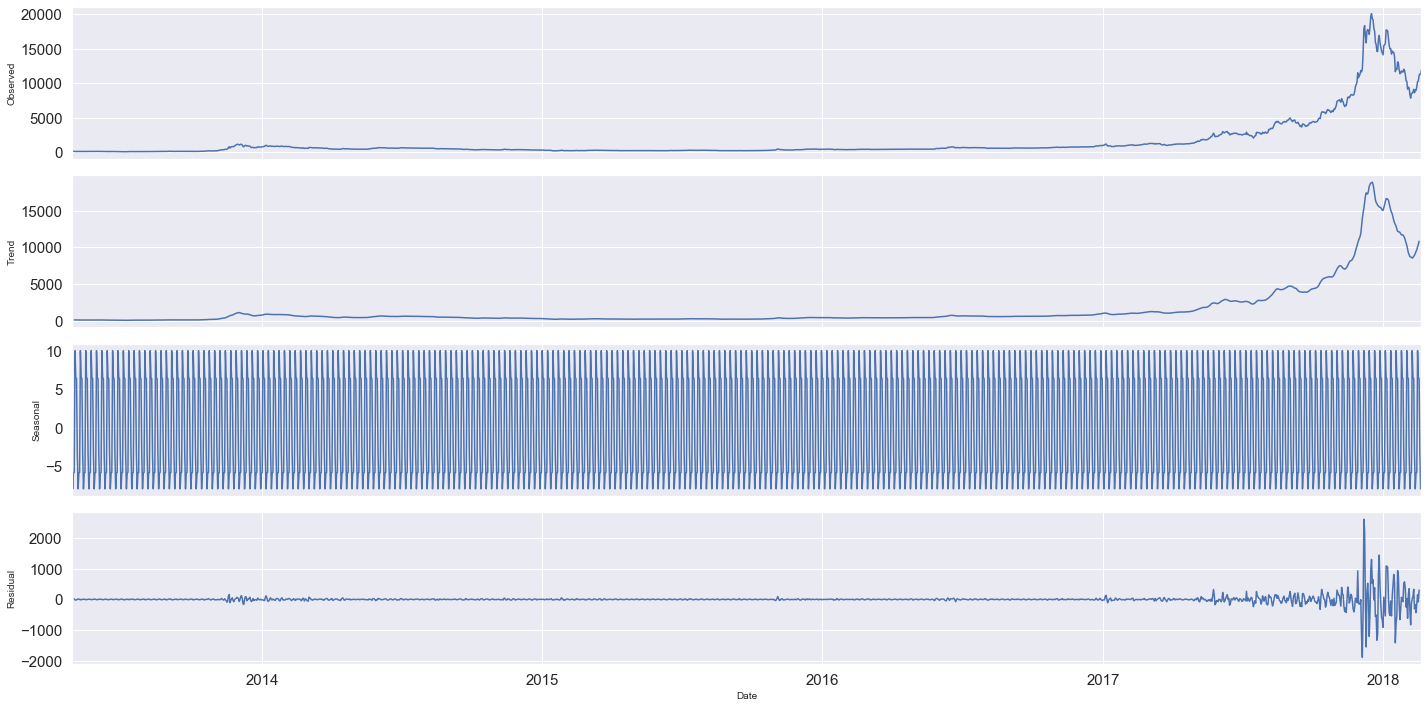

Dickey–Fuller test: p=0.998891


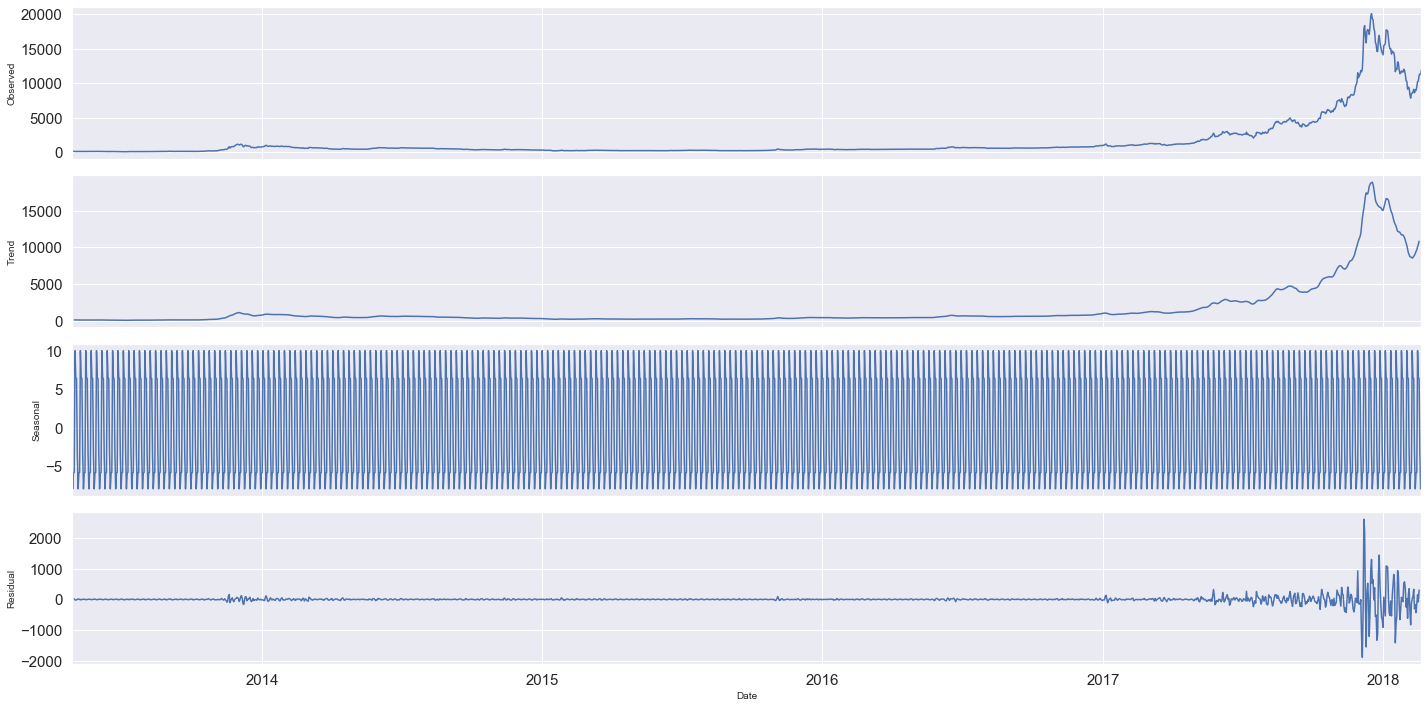

In [175]:
seasonal_decompose(bitcoinPrice_df.High, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.High)[1])

In [6]:
# Get last date in training set
print((bitcoinPrice_df).sort_values('Date').head(1))

           Date   Open    High    Low   Close Volume     Market Cap
1759 2013-04-28  135.3  135.98  132.1  134.21      -  1,500,520,000


In [167]:
bitcoinPrice_df['Date'] = pd.to_datetime(bitcoinPrice_df['Date'])
bitcoinPrice_df.set_axis(bitcoinPrice_df['Date'], inplace=True)
bitcoinPrice_df.drop(columns=['Open', 'Low', 'Close', 'Volume', 'Market Cap'], inplace=True)

In [9]:
bitcoinPrice_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1760 entries, 2013-04-28 to 2018-02-20
Data columns (total 2 columns):
Date    1760 non-null datetime64[ns]
High    1760 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.2 KB


In [10]:
# Get last date in training set
print(bitcoinPrice_df.tail(1))

                 Date     High
Date                          
2018-02-20 2018-02-20  11958.5


In [11]:
train_data = bitcoinPrice_df['High'].values
train_data = train_data.reshape((-1,1))

split_percent = 0.70
split = int(split_percent*len(train_data))

train = train_data[:split]
test = train_data[split:]

train_dt = bitcoinPrice_df['Date'][:split]
test_dt = bitcoinPrice_df['Date'][split:]

# Check length of train and test splits
print(len(train))
print(len(test))

1232
528


In [12]:
look_back = 15

train_generator = TimeseriesGenerator(train, train, length = look_back, batch_size=20)     
test_generator = TimeseriesGenerator(test, test, length = look_back, batch_size=1)

In [13]:
# Might not use this code block
# Scale the data
#high_price = bitcoinPrice_df.High.values.reshape(-1, 1)
high_price = bitcoinPrice_df.High.values.reshape(-1, 1)
scaled_high_price = sc.fit_transform(high_price)

# Remove NaNs
scaled_high_price = scaled_high_price[~np.isnan(scaled_high_price)]
scaled_high_price = scaled_high_price.reshape(-1, 1)

In [14]:
# Splitting a little differently for data generator, may not use this block
X_train, y_train, X_test, y_test = preprocess(scaled_high_price, SEQ_LEN, train_split = 0.7)

In [19]:
# Set up k-fold
kf = KFold(n_splits = 10)
skf = StratifiedKFold(n_splits = 10, random_state = 7, shuffle = True)
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

In [65]:
# LSTM Model

fold_var = 1
for train_index, val_index in kf.split(np.zeros(1760),train_data):
    training_data = bitcoinPrice_df.iloc[train_index]
    validation_data = bitcoinPrice_df.iloc[val_index]
    
    validation_data = validation_data['High'].values
    
    validation_data = validation_data.reshape((-1,1))
    
    valid_data_generator = TimeseriesGenerator(validation_data, validation_data, length = look_back, batch_size=20)
    
    lstm_model = Sequential()
    lstm_model.add(
        LSTM(100,
            activation='relu',
            input_shape=(look_back,1))
    )

    lstm_model.add(Dense(1))

    lstm_model.compile(optimizer='adam', loss='mae', metrics = ['mae'])
    
    checkpoint = callback.ModelCheckpoint(get_model_name(fold_var),
                                          monitor = 'val_', verbose = 1,
                                          save_best_only = True, mode = 'max')
    callbacks_list = [checkpoint]
    
    num_epochs = 100
    lstm_model.fit(train_generator, validation_data = valid_data_generator, epochs = num_epochs, validation_steps=.3, verbose=1)

    lstm_model.save_weights('my_weights.hdf5')
    lstm_model.load_weights('my_weights.hdf5')
    
    results = lstm_model.evaluate(valid_data_generator)
    results = dict(zip(lstm_model.metrics_names, results))
    
    VALIDATION_ACCURACY.append(results['mae'])
    VALIDATION_LOSS.append(results['loss'])
    
    keras.backend.clear_session()
    
    fold_var += 1

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 32ms/step - loss: 200.0846 - mae: 200.2471 - val_loss: 34.6216 - val_mae: 10.3865
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 53.7133 - mae: 53.8125 - val_loss: 83.7433 - val_mae: 25.1230
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 33.3321 - mae: 33.3675 - val_loss: 14.1386 - val_mae: 4.2416
Epoch 4/100
61/61 [==============================] - 1s 12ms/step - loss: 36.4804 - mae: 36.5268 - val_loss: 20.7981 - val_mae: 6.2394
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 34.1566 - mae: 34.1606 - val_loss: 12.9184 - val_mae: 3.8755
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 27.2598 - mae: 27.2263 - val_loss: 11.8096 - val_mae: 3.5429
Epoch 7/100
61/61 [==============================] - 1s 11ms/step - loss: 29.0840 - mae: 29.1

61/61 [==============================] - 1s 10ms/step - loss: 22.2363 - mae: 22.1856 - val_loss: 12.8270 - val_mae: 3.8481
Epoch 60/100
61/61 [==============================] - 1s 11ms/step - loss: 18.2314 - mae: 18.2455 - val_loss: 12.4672 - val_mae: 3.7401
Epoch 61/100
61/61 [==============================] - 1s 11ms/step - loss: 17.7904 - mae: 17.8002 - val_loss: 13.9120 - val_mae: 4.1736
Epoch 62/100
61/61 [==============================] - 1s 11ms/step - loss: 226.2768 - mae: 226.7929 - val_loss: 38.4402 - val_mae: 11.5321
Epoch 63/100
61/61 [==============================] - 1s 11ms/step - loss: 46.6249 - mae: 46.6587 - val_loss: 24.8086 - val_mae: 7.4426
Epoch 64/100
61/61 [==============================] - 1s 11ms/step - loss: 41.3774 - mae: 41.4359 - val_loss: 22.2398 - val_mae: 6.6719
Epoch 65/100
61/61 [==============================] - 1s 10ms/step - loss: 40.0049 - mae: 39.8549 - val_loss: 24.9749 - val_mae: 7.4925
Epoch 66/100
61/61 [==============================] - 1s 1

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 7.1578 - mae: 5.9163
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 38ms/step - loss: 138.0045 - mae: 138.0731 - val_loss: 410.4868 - val_mae: 123.1460
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 80.4874 - mae: 80.5285 - val_loss: 797.4095 - val_mae: 239.2229
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 36.7331 - mae: 36.7913 - val_loss: 660.7889 - val_mae: 198.2367
Epoch 4/100
61/61 [==============================] - 1s 12ms/step - loss: 35.8627 - mae: 35.9151 - val_loss: 733.8555 - val_mae: 220.1566
Epoch 5/100
61/61 [==============================] - 1s 10ms/step - loss: 34.9370 - mae: 34.9772 - val_loss: 617.9786 - val_mae: 185.3936
Epoch 6/100
61/61 [==============================] - 1s 10ms/step - loss: 25.6759 - mae: 25.6697 - val_loss: 5

61/61 [==============================] - 1s 11ms/step - loss: 16.7345 - mae: 16.7444 - val_loss: 340.2674 - val_mae: 102.0802
Epoch 58/100
61/61 [==============================] - 1s 12ms/step - loss: 20.8709 - mae: 20.8807 - val_loss: 414.9040 - val_mae: 124.4712
Epoch 59/100
61/61 [==============================] - 1s 11ms/step - loss: 20.8988 - mae: 20.8945 - val_loss: 388.5060 - val_mae: 116.5518
Epoch 60/100
61/61 [==============================] - 1s 11ms/step - loss: 17.1354 - mae: 17.1136 - val_loss: 328.7628 - val_mae: 98.6288
Epoch 61/100
61/61 [==============================] - 1s 11ms/step - loss: 18.6188 - mae: 18.6398 - val_loss: 321.9533 - val_mae: 96.5860
Epoch 62/100
61/61 [==============================] - 1s 11ms/step - loss: 17.7365 - mae: 17.7599 - val_loss: 292.0706 - val_mae: 87.6212
Epoch 63/100
61/61 [==============================] - 1s 12ms/step - loss: 15.7582 - mae: 15.7746 - val_loss: 315.8170 - val_mae: 94.7451
Epoch 64/100
61/61 [========================

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 35.7695 - mae: 36.1247
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 32ms/step - loss: 175.2683 - mae: 175.6425 - val_loss: 301.9892 - val_mae: 90.5968
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 66.3212 - mae: 66.2034 - val_loss: 69.4213 - val_mae: 20.8264
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 42.7621 - mae: 42.6596 - val_loss: 82.4350 - val_mae: 24.7305
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 46.1435 - mae: 46.0899 - val_loss: 66.6065 - val_mae: 19.9819
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 44.9152 - mae: 44.9717 - val_loss: 52.8368 - val_mae: 15.8510
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 51.5689 - mae: 51.6564 - val_loss: 47.4419 

61/61 [==============================] - 1s 11ms/step - loss: 16.6207 - mae: 16.6210 - val_loss: 30.0290 - val_mae: 9.0087
Epoch 59/100
61/61 [==============================] - 1s 11ms/step - loss: 17.0368 - mae: 17.0550 - val_loss: 23.9701 - val_mae: 7.1910
Epoch 60/100
61/61 [==============================] - 1s 11ms/step - loss: 16.9344 - mae: 16.9419 - val_loss: 32.5055 - val_mae: 9.7517
Epoch 61/100
61/61 [==============================] - 1s 11ms/step - loss: 17.1131 - mae: 17.0959 - val_loss: 40.7930 - val_mae: 12.2379
Epoch 62/100
61/61 [==============================] - 1s 11ms/step - loss: 16.8328 - mae: 16.8516 - val_loss: 29.0338 - val_mae: 8.7101
Epoch 63/100
61/61 [==============================] - 1s 11ms/step - loss: 17.8791 - mae: 17.9002 - val_loss: 26.3094 - val_mae: 7.8928
Epoch 64/100
61/61 [==============================] - 1s 11ms/step - loss: 17.9096 - mae: 17.9292 - val_loss: 16.0552 - val_mae: 4.8166
Epoch 65/100
61/61 [==============================] - 1s 11m

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 12.1733 - mae: 12.2544
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 31ms/step - loss: 100.1808 - mae: 100.2826 - val_loss: 67.7347 - val_mae: 20.3204
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 28.6206 - mae: 28.6517 - val_loss: 92.9981 - val_mae: 27.8994
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 33.2317 - mae: 33.2115 - val_loss: 73.4983 - val_mae: 22.0495
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 33.3380 - mae: 33.3669 - val_loss: 72.1707 - val_mae: 21.6512
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 30.7303 - mae: 30.7472 - val_loss: 68.4585 - val_mae: 20.5376
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 30.8192 - mae: 30.8123 - val_loss: 91.1485 -

61/61 [==============================] - 1s 11ms/step - loss: 19.4792 - mae: 19.4847 - val_loss: 44.3391 - val_mae: 13.3017
Epoch 59/100
61/61 [==============================] - 1s 11ms/step - loss: 19.7371 - mae: 19.7257 - val_loss: 41.9967 - val_mae: 12.5990
Epoch 60/100
61/61 [==============================] - 1s 11ms/step - loss: 18.5344 - mae: 18.5540 - val_loss: 48.2756 - val_mae: 14.4827
Epoch 61/100
61/61 [==============================] - 1s 11ms/step - loss: 18.2911 - mae: 18.2879 - val_loss: 51.7866 - val_mae: 15.5360
Epoch 62/100
61/61 [==============================] - 1s 11ms/step - loss: 18.8675 - mae: 18.8860 - val_loss: 45.3387 - val_mae: 13.6016
Epoch 63/100
61/61 [==============================] - 1s 11ms/step - loss: 18.0353 - mae: 18.0320 - val_loss: 41.5732 - val_mae: 12.4720
Epoch 64/100
61/61 [==============================] - 1s 11ms/step - loss: 17.7996 - mae: 17.8155 - val_loss: 41.0612 - val_mae: 12.3184
Epoch 65/100
61/61 [==============================] - 

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 11.0551 - mae: 12.0024
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 32ms/step - loss: 153.0578 - mae: 152.6266 - val_loss: 23.0425 - val_mae: 6.9128
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 36.1437 - mae: 36.1087 - val_loss: 55.9597 - val_mae: 16.7879
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 53.5889 - mae: 53.4890 - val_loss: 29.9363 - val_mae: 8.9809
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 34.7798 - mae: 34.8171 - val_loss: 28.3627 - val_mae: 8.5088
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 30.8249 - mae: 30.8556 - val_loss: 23.6038 - val_mae: 7.0811
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 31.5908 - mae: 31.6286 - val_loss: 27.0466 - val

61/61 [==============================] - 1s 12ms/step - loss: 23.0923 - mae: 23.0807 - val_loss: 17.0731 - val_mae: 5.1219
Epoch 59/100
61/61 [==============================] - 1s 11ms/step - loss: 34.3017 - mae: 34.2410 - val_loss: 19.7902 - val_mae: 5.9370
Epoch 60/100
61/61 [==============================] - 1s 11ms/step - loss: 19.5018 - mae: 19.5206 - val_loss: 18.0601 - val_mae: 5.4180
Epoch 61/100
61/61 [==============================] - 1s 11ms/step - loss: 20.2882 - mae: 20.3081 - val_loss: 19.8424 - val_mae: 5.9527
Epoch 62/100
61/61 [==============================] - 1s 11ms/step - loss: 20.1461 - mae: 20.1614 - val_loss: 21.3695 - val_mae: 6.4108
Epoch 63/100
61/61 [==============================] - 1s 11ms/step - loss: 22.4658 - mae: 22.4907 - val_loss: 18.5227 - val_mae: 5.5568
Epoch 64/100
61/61 [==============================] - 1s 11ms/step - loss: 19.9155 - mae: 19.9344 - val_loss: 16.4806 - val_mae: 4.9442
Epoch 65/100
61/61 [==============================] - 1s 11ms

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 6.3555 - mae: 6.3491
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 34ms/step - loss: 204.5030 - mae: 204.8642 - val_loss: 257.9353 - val_mae: 77.3806
Epoch 2/100
61/61 [==============================] - 1s 12ms/step - loss: 59.3313 - mae: 59.2286 - val_loss: 64.8021 - val_mae: 19.4406
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 32.2690 - mae: 32.2550 - val_loss: 21.2303 - val_mae: 6.3691
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 30.5007 - mae: 30.5180 - val_loss: 158.3145 - val_mae: 47.4944
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 30.4538 - mae: 30.4913 - val_loss: 49.4693 - val_mae: 14.8408
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 43.4861 - mae: 43.1943 - val_loss: 205.2429 -

61/61 [==============================] - 1s 11ms/step - loss: 31.1736 - mae: 31.0808 - val_loss: 45.1802 - val_mae: 13.5540
Epoch 59/100
61/61 [==============================] - 1s 11ms/step - loss: 38.4159 - mae: 38.3434 - val_loss: 79.0497 - val_mae: 23.7149
Epoch 60/100
61/61 [==============================] - 1s 10ms/step - loss: 27.7237 - mae: 27.6584 - val_loss: 60.8543 - val_mae: 18.2563
Epoch 61/100
61/61 [==============================] - 1s 11ms/step - loss: 27.7650 - mae: 27.7604 - val_loss: 27.3402 - val_mae: 8.2021
Epoch 62/100
61/61 [==============================] - 1s 11ms/step - loss: 25.8721 - mae: 25.8973 - val_loss: 86.0150 - val_mae: 25.8045
Epoch 63/100
61/61 [==============================] - 1s 11ms/step - loss: 24.0988 - mae: 24.0538 - val_loss: 51.8907 - val_mae: 15.5672
Epoch 64/100
61/61 [==============================] - 1s 11ms/step - loss: 23.2961 - mae: 23.3111 - val_loss: 27.4158 - val_mae: 8.2247
Epoch 65/100
61/61 [==============================] - 1s

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 11.0129 - mae: 11.9701
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 38ms/step - loss: 206.0280 - mae: 204.9686 - val_loss: 35.7798 - val_mae: 10.7339
Epoch 2/100
61/61 [==============================] - 1s 10ms/step - loss: 41.1497 - mae: 41.1869 - val_loss: 15.9798 - val_mae: 4.7939
Epoch 3/100
61/61 [==============================] - 1s 10ms/step - loss: 34.9362 - mae: 34.9783 - val_loss: 52.4989 - val_mae: 15.7497
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 33.9127 - mae: 33.9151 - val_loss: 15.2771 - val_mae: 4.5831
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 35.1781 - mae: 35.2247 - val_loss: 83.1189 - val_mae: 24.9357
Epoch 6/100
61/61 [==============================] - 1s 10ms/step - loss: 33.5025 - mae: 33.5406 - val_loss: 48.2613 - v

61/61 [==============================] - 1s 11ms/step - loss: 16.5150 - mae: 16.5045 - val_loss: 39.6344 - val_mae: 11.8903
Epoch 59/100
61/61 [==============================] - 1s 11ms/step - loss: 17.7328 - mae: 17.7375 - val_loss: 87.3913 - val_mae: 26.2174
Epoch 60/100
61/61 [==============================] - 1s 10ms/step - loss: 17.8269 - mae: 17.8356 - val_loss: 13.0322 - val_mae: 3.9097
Epoch 61/100
61/61 [==============================] - 1s 11ms/step - loss: 14.7665 - mae: 14.7842 - val_loss: 8.5956 - val_mae: 2.5787
Epoch 62/100
61/61 [==============================] - 1s 10ms/step - loss: 16.5098 - mae: 16.5047 - val_loss: 26.4801 - val_mae: 7.9440
Epoch 63/100
61/61 [==============================] - 1s 10ms/step - loss: 15.3951 - mae: 15.4098 - val_loss: 33.8683 - val_mae: 10.1605
Epoch 64/100
61/61 [==============================] - 1s 11ms/step - loss: 14.2253 - mae: 14.2026 - val_loss: 18.2905 - val_mae: 5.4872
Epoch 65/100
61/61 [==============================] - 1s 10

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 11.1297 - mae: 12.1520
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 34ms/step - loss: 262.3646 - mae: 262.9211 - val_loss: 311.5310 - val_mae: 93.4593
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 77.0571 - mae: 77.0386 - val_loss: 116.1599 - val_mae: 34.8480
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 95.2200 - mae: 95.3682 - val_loss: 95.8884 - val_mae: 28.7665
Epoch 4/100
61/61 [==============================] - 1s 12ms/step - loss: 78.0369 - mae: 78.0688 - val_loss: 309.1823 - val_mae: 92.7547
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 56.0675 - mae: 55.9468 - val_loss: 187.5492 - val_mae: 56.2647
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 44.9024 - mae: 44.9449 - val_loss: 208.7

61/61 [==============================] - 1s 11ms/step - loss: 51.2490 - mae: 51.0175 - val_loss: 283.3085 - val_mae: 84.9925
Epoch 59/100
61/61 [==============================] - 1s 11ms/step - loss: 37.2486 - mae: 37.3031 - val_loss: 327.9339 - val_mae: 98.3802
Epoch 60/100
61/61 [==============================] - 1s 10ms/step - loss: 39.0011 - mae: 39.0506 - val_loss: 216.1986 - val_mae: 64.8596
Epoch 61/100
61/61 [==============================] - 1s 10ms/step - loss: 26.4677 - mae: 26.4939 - val_loss: 178.4652 - val_mae: 53.5396
Epoch 62/100
61/61 [==============================] - 1s 10ms/step - loss: 35.3863 - mae: 35.3623 - val_loss: 25.8623 - val_mae: 7.7587
Epoch 63/100
61/61 [==============================] - 1s 10ms/step - loss: 30.9181 - mae: 30.9532 - val_loss: 72.8168 - val_mae: 21.8450
Epoch 64/100
61/61 [==============================] - 1s 10ms/step - loss: 30.5469 - mae: 30.5576 - val_loss: 54.8480 - val_mae: 16.4544
Epoch 65/100
61/61 [==============================]

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 49.0100 - mae: 50.3748
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 32ms/step - loss: 201.3027 - mae: 200.9158 - val_loss: 648.5526 - val_mae: 194.5658
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 81.6019 - mae: 81.4383 - val_loss: 388.8229 - val_mae: 116.6469
Epoch 3/100
61/61 [==============================] - 1s 10ms/step - loss: 41.1655 - mae: 41.1377 - val_loss: 316.4065 - val_mae: 94.9219
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 25.5803 - mae: 25.6058 - val_loss: 161.3647 - val_mae: 48.4094
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 21.4429 - mae: 21.4765 - val_loss: 194.7052 - val_mae: 58.4116
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 24.0994 - mae: 24.1235 - val_loss: 14

Epoch 58/100
61/61 [==============================] - 1s 11ms/step - loss: 18.7209 - mae: 18.6707 - val_loss: 113.8594 - val_mae: 34.1578
Epoch 59/100
61/61 [==============================] - 1s 11ms/step - loss: 18.5073 - mae: 18.5118 - val_loss: 192.4389 - val_mae: 57.7317
Epoch 60/100
61/61 [==============================] - 1s 11ms/step - loss: 16.0826 - mae: 16.1001 - val_loss: 176.9373 - val_mae: 53.0812
Epoch 61/100
61/61 [==============================] - 1s 10ms/step - loss: 16.5669 - mae: 16.5834 - val_loss: 146.9707 - val_mae: 44.0912
Epoch 62/100
61/61 [==============================] - 1s 11ms/step - loss: 17.7919 - mae: 17.7859 - val_loss: 144.1519 - val_mae: 43.2456
Epoch 63/100
61/61 [==============================] - 1s 11ms/step - loss: 17.7282 - mae: 17.7494 - val_loss: 98.4659 - val_mae: 29.5398
Epoch 64/100
61/61 [==============================] - 1s 10ms/step - loss: 17.1056 - mae: 17.0913 - val_loss: 116.5595 - val_mae: 34.9678
Epoch 65/100
61/61 [===============

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 99.4901 - mae: 104.4847
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 2s 31ms/step - loss: 91.5747 - mae: 91.3034 - val_loss: 955.3062 - val_mae: 286.5919
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 31.3283 - mae: 31.3671 - val_loss: 1192.4382 - val_mae: 357.7314
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 28.1225 - mae: 28.1045 - val_loss: 1140.6106 - val_mae: 342.1832
Epoch 4/100
61/61 [==============================] - 1s 11ms/step - loss: 29.8090 - mae: 29.7675 - val_loss: 963.3059 - val_mae: 288.9918
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 29.2009 - mae: 29.1733 - val_loss: 855.7922 - val_mae: 256.7377
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 26.9850 - mae: 26.9903 - val_loss

61/61 [==============================] - 1s 11ms/step - loss: 17.3513 - mae: 17.3711 - val_loss: 536.5712 - val_mae: 160.9714
Epoch 58/100
61/61 [==============================] - 1s 11ms/step - loss: 15.2293 - mae: 15.2442 - val_loss: 650.6184 - val_mae: 195.1855
Epoch 59/100
61/61 [==============================] - 1s 11ms/step - loss: 16.2690 - mae: 16.2859 - val_loss: 732.4800 - val_mae: 219.7440
Epoch 60/100
61/61 [==============================] - 1s 12ms/step - loss: 15.4371 - mae: 15.4420 - val_loss: 672.0676 - val_mae: 201.6203
Epoch 61/100
61/61 [==============================] - 1s 12ms/step - loss: 18.8615 - mae: 18.8162 - val_loss: 593.1523 - val_mae: 177.9457
Epoch 62/100
61/61 [==============================] - 1s 13ms/step - loss: 15.8657 - mae: 15.8652 - val_loss: 568.7427 - val_mae: 170.6228
Epoch 63/100
61/61 [==============================] - 1s 11ms/step - loss: 15.9747 - mae: 15.9899 - val_loss: 554.5367 - val_mae: 166.3610
Epoch 64/100
61/61 [====================

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 543.2459 - mae: 535.3129


In [82]:
# Build RNN model
fold_var = 1
DROPOUT = 0.2
SEQ_LEN = 100
WINDOW_SIZE = SEQ_LEN -1
BATCH_SIZE = 64

for train_index, val_index in kf.split(np.zeros(1760),train_data):
    training_data = bitcoinPrice_df.iloc[train_index]
    validation_data = bitcoinPrice_df.iloc[val_index]
    
    validation_data = validation_data['High'].values
    
    validation_data = validation_data.reshape((-1,1))
    
    valid_data_generator = TimeseriesGenerator(validation_data, validation_data, length = look_back, batch_size=20)
    
    rnn_model = Sequential()
    rnn_model.add(Bidirectional(
        LSTM(WINDOW_SIZE, return_sequences = True, dropout = DROPOUT),
            input_shape=(look_back,1))
    )
    
    rnn_model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences = True, dropout = DROPOUT)))
    
    rnn_model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences = False, dropout = DROPOUT)))
    
    rnn_model.add(Dense(1))
    
    rnn_model.add(Activation('relu'))

    rnn_model.compile(optimizer='adam', loss='mae', metrics = ['mae'])
    
    checkpoint = callback.ModelCheckpoint(get_model_name(fold_var),
                                          monitor = 'val_', verbose = 1,
                                          save_best_only = True, mode = 'max')
    callbacks_list = [checkpoint]
    
    num_epochs = 100
    rnn_model.fit(train_generator, validation_data = valid_data_generator, epochs = num_epochs, validation_steps=.3, verbose=1)

    #rnn_model.load_weights("/saved_models/model_"+str(fold_var)+".h10")
    #rnn_model.load_weights("C:\\saved_models\\model_"+str(fold_var)+".h5")
    rnn_model.save_weights('my_weights.hdf5')
    rnn_model.load_weights('my_weights.hdf5')
    
    results = rnn_model.evaluate(valid_data_generator)
    results = dict(zip(rnn_model.metrics_names, results))
    
    VALIDATION_ACCURACY.append(results['mae'])
    VALIDATION_LOSS.append(results['loss'])
    
    keras.backend.clear_session()
    
    fold_var += 1

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 14s 223ms/step - loss: 406.2384 - mae: 405.7790 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 2/100
61/61 [==============================] - 4s 66ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 3/100
61/61 [==============================] - 4s 66ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 4/100
61/61 [==============================] - 4s 67ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 5/100
61/61 [==============================] - 4s 67ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 6/100
61/61 [==============================] - 4s 67ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 7/100
61/61 [==============================] - 4s 68ms/step

Epoch 58/100
61/61 [==============================] - 4s 70ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 59/100
61/61 [==============================] - 4s 69ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 60/100
61/61 [==============================] - 4s 70ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 61/100
61/61 [==============================] - 4s 72ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 62/100
61/61 [==============================] - 4s 69ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 63/100
61/61 [==============================] - 4s 70ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 64/100
61/61 [==============================] - 4s 70ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 423.2183 - val_mae: 126.9655
Epoch 65/100


  ...
    to  
  ['...']
9/9 [==============================] - 0s 12ms/step - loss: 124.4969 - mae: 118.5475
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 13s 220ms/step - loss: 386.7975 - mae: 386.3250 - val_loss: 1589.5925 - val_mae: 476.8777
Epoch 2/100
61/61 [==============================] - 4s 70ms/step - loss: 371.8348 - mae: 371.3735 - val_loss: 1546.2796 - val_mae: 463.8839
Epoch 3/100
61/61 [==============================] - 4s 70ms/step - loss: 359.0678 - mae: 358.6071 - val_loss: 1504.3414 - val_mae: 451.3024
Epoch 4/100
61/61 [==============================] - 4s 70ms/step - loss: 346.5813 - mae: 346.1116 - val_loss: 1462.8851 - val_mae: 438.8655
Epoch 5/100
61/61 [==============================] - 4s 71ms/step - loss: 334.1096 - mae: 333.6353 - val_loss: 1421.3311 - val_mae: 426.3993
Epoch 6/100
61/61 [==============================] - 4s 71ms/step - loss: 321.8185 - mae: 

Epoch 56/100
61/61 [==============================] - 4s 70ms/step - loss: 104.1002 - mae: 103.8617 - val_loss: 758.7157 - val_mae: 227.6147
Epoch 57/100
61/61 [==============================] - 4s 70ms/step - loss: 115.7849 - mae: 115.5296 - val_loss: 1068.6141 - val_mae: 320.5842
Epoch 58/100
61/61 [==============================] - 4s 70ms/step - loss: 108.8349 - mae: 108.5803 - val_loss: 1009.7679 - val_mae: 302.9304
Epoch 59/100
61/61 [==============================] - 4s 70ms/step - loss: 105.7023 - mae: 105.4646 - val_loss: 1028.5636 - val_mae: 308.5691
Epoch 60/100
61/61 [==============================] - 4s 70ms/step - loss: 103.9569 - mae: 103.7294 - val_loss: 836.9400 - val_mae: 251.0820
Epoch 61/100
61/61 [==============================] - 4s 71ms/step - loss: 100.9097 - mae: 100.6827 - val_loss: 1026.3898 - val_mae: 307.9169
Epoch 62/100
61/61 [==============================] - 4s 72ms/step - loss: 100.2365 - mae: 100.0152 - val_loss: 914.7197 - val_mae: 274.4159
Epoch 63/

  ...
    to  
  ['...']
9/9 [==============================] - 0s 11ms/step - loss: 236.4097 - mae: 255.3082
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 13s 220ms/step - loss: 384.7903 - mae: 384.3209 - val_loss: 1397.0478 - val_mae: 419.1143
Epoch 2/100
61/61 [==============================] - 4s 69ms/step - loss: 369.7473 - mae: 369.2925 - val_loss: 1354.8099 - val_mae: 406.4430
Epoch 3/100
61/61 [==============================] - 4s 70ms/step - loss: 357.2400 - mae: 356.7742 - val_loss: 1313.5494 - val_mae: 394.0648
Epoch 4/100
61/61 [==============================] - 4s 70ms/step - loss: 344.8646 - mae: 344.4146 - val_loss: 1272.2992 - val_mae: 381.6898
Epoch 5/100
61/61 [==============================] - 4s 70ms/step - loss: 332.5487 - mae: 332.0782 - val_loss: 1231.4244 - val_mae: 369.4273
Epoch 6/100
61/61 [==============================] - 4s 70ms/step - loss: 320.4312 - mae: 

61/61 [==============================] - 4s 70ms/step - loss: 111.8512 - mae: 111.5923 - val_loss: 249.9332 - val_mae: 74.9800
Epoch 57/100
61/61 [==============================] - 4s 71ms/step - loss: 108.0077 - mae: 107.7562 - val_loss: 219.1314 - val_mae: 65.7394
Epoch 58/100
61/61 [==============================] - 4s 70ms/step - loss: 105.9363 - mae: 105.6877 - val_loss: 225.7271 - val_mae: 67.7181
Epoch 59/100
61/61 [==============================] - 4s 70ms/step - loss: 103.4283 - mae: 103.1784 - val_loss: 185.0506 - val_mae: 55.5152
Epoch 60/100
61/61 [==============================] - 4s 70ms/step - loss: 104.8961 - mae: 104.6722 - val_loss: 171.6407 - val_mae: 51.4922
Epoch 61/100
61/61 [==============================] - 4s 70ms/step - loss: 99.4657 - mae: 99.2317 - val_loss: 242.6923 - val_mae: 72.8077
Epoch 62/100
61/61 [==============================] - 4s 70ms/step - loss: 98.3543 - mae: 98.1348 - val_loss: 148.2394 - val_mae: 44.4718
Epoch 63/100
61/61 [=================

  ...
    to  
  ['...']
9/9 [==============================] - 0s 12ms/step - loss: 71.9916 - mae: 73.1430
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 13s 217ms/step - loss: 385.7288 - mae: 385.2800 - val_loss: 1083.8793 - val_mae: 325.1638
Epoch 2/100
61/61 [==============================] - 4s 70ms/step - loss: 370.7947 - mae: 370.3314 - val_loss: 1041.1631 - val_mae: 312.3489
Epoch 3/100
61/61 [==============================] - 4s 71ms/step - loss: 358.1590 - mae: 357.6852 - val_loss: 999.3219 - val_mae: 299.7966
Epoch 4/100
61/61 [==============================] - 4s 70ms/step - loss: 345.6621 - mae: 345.1880 - val_loss: 957.9364 - val_mae: 287.3809
Epoch 5/100
61/61 [==============================] - 4s 71ms/step - loss: 333.3007 - mae: 332.8315 - val_loss: 916.8768 - val_mae: 275.0630
Epoch 6/100
61/61 [==============================] - 4s 70ms/step - loss: 321.1256 - mae: 320.6

Epoch 57/100
61/61 [==============================] - 4s 70ms/step - loss: 95.1100 - mae: 94.8889 - val_loss: 217.3652 - val_mae: 65.2096
Epoch 58/100
61/61 [==============================] - 4s 70ms/step - loss: 94.4188 - mae: 94.1824 - val_loss: 167.4236 - val_mae: 50.2271
Epoch 59/100
61/61 [==============================] - 4s 73ms/step - loss: 92.0791 - mae: 91.8729 - val_loss: 365.6929 - val_mae: 109.7079
Epoch 60/100
61/61 [==============================] - 5s 75ms/step - loss: 89.9219 - mae: 89.7146 - val_loss: 262.2230 - val_mae: 78.6669
Epoch 61/100
61/61 [==============================] - 4s 72ms/step - loss: 89.9777 - mae: 89.7829 - val_loss: 267.6193 - val_mae: 80.2858
Epoch 62/100
61/61 [==============================] - 4s 73ms/step - loss: 87.1158 - mae: 86.9254 - val_loss: 337.9620 - val_mae: 101.3886
Epoch 63/100
61/61 [==============================] - 4s 73ms/step - loss: 84.4033 - mae: 84.2133 - val_loss: 160.0270 - val_mae: 48.0081
Epoch 64/100
61/61 [============

  ...
    to  
  ['...']
9/9 [==============================] - 0s 11ms/step - loss: 48.8379 - mae: 53.5596
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 15s 253ms/step - loss: 385.5884 - mae: 385.1342 - val_loss: 682.1265 - val_mae: 204.6379
Epoch 2/100
61/61 [==============================] - 4s 73ms/step - loss: 370.6548 - mae: 370.1981 - val_loss: 639.2876 - val_mae: 191.7863
Epoch 3/100
61/61 [==============================] - 4s 71ms/step - loss: 357.9547 - mae: 357.4848 - val_loss: 597.3100 - val_mae: 179.1930
Epoch 4/100
61/61 [==============================] - 4s 73ms/step - loss: 345.4038 - mae: 344.9590 - val_loss: 555.4662 - val_mae: 166.6398
Epoch 5/100
61/61 [==============================] - 4s 72ms/step - loss: 332.9058 - mae: 332.4395 - val_loss: 514.0388 - val_mae: 154.2116
Epoch 6/100
61/61 [==============================] - 4s 72ms/step - loss: 320.6152 - mae: 320.157

61/61 [==============================] - 4s 70ms/step - loss: 110.4474 - mae: 110.1891 - val_loss: 51.1671 - val_mae: 15.3501
Epoch 58/100
61/61 [==============================] - 4s 71ms/step - loss: 116.5851 - mae: 116.3559 - val_loss: 44.5330 - val_mae: 13.3599
Epoch 59/100
61/61 [==============================] - 4s 71ms/step - loss: 105.3155 - mae: 105.0696 - val_loss: 83.9877 - val_mae: 25.1963
Epoch 60/100
61/61 [==============================] - 4s 71ms/step - loss: 101.9285 - mae: 101.6892 - val_loss: 66.2170 - val_mae: 19.8651
Epoch 61/100
61/61 [==============================] - 4s 72ms/step - loss: 102.6142 - mae: 102.3907 - val_loss: 57.7861 - val_mae: 17.3358
Epoch 62/100
61/61 [==============================] - 5s 76ms/step - loss: 102.4090 - mae: 102.1930 - val_loss: 22.4882 - val_mae: 6.7465
Epoch 63/100
61/61 [==============================] - 5s 75ms/step - loss: 97.3996 - mae: 97.1803 - val_loss: 30.3297 - val_mae: 9.0989
Epoch 64/100
61/61 [========================

  ...
    to  
  ['...']
9/9 [==============================] - 0s 12ms/step - loss: 14.9660 - mae: 16.4374
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 16s 265ms/step - loss: 385.5208 - mae: 385.0215 - val_loss: 811.0810 - val_mae: 243.3243
Epoch 2/100
61/61 [==============================] - 4s 73ms/step - loss: 370.4153 - mae: 369.9416 - val_loss: 768.1372 - val_mae: 230.4412
Epoch 3/100
61/61 [==============================] - 4s 72ms/step - loss: 357.7306 - mae: 357.2648 - val_loss: 726.3227 - val_mae: 217.8968
Epoch 4/100
61/61 [==============================] - 4s 71ms/step - loss: 345.2591 - mae: 344.8009 - val_loss: 684.9460 - val_mae: 205.4838
Epoch 5/100
61/61 [==============================] - 4s 73ms/step - loss: 332.8960 - mae: 332.4259 - val_loss: 643.8765 - val_mae: 193.1629
Epoch 6/100
61/61 [==============================] - 4s 73ms/step - loss: 320.7209 - mae: 320.266

Epoch 57/100
61/61 [==============================] - 4s 71ms/step - loss: 119.6785 - mae: 119.4226 - val_loss: 71.6074 - val_mae: 21.4822
Epoch 58/100
61/61 [==============================] - 4s 71ms/step - loss: 110.2572 - mae: 110.0046 - val_loss: 80.0934 - val_mae: 24.0280
Epoch 59/100
61/61 [==============================] - 4s 73ms/step - loss: 106.9138 - mae: 106.6660 - val_loss: 104.8708 - val_mae: 31.4613
Epoch 60/100
61/61 [==============================] - 4s 73ms/step - loss: 106.4995 - mae: 106.2586 - val_loss: 401.7705 - val_mae: 120.5311
Epoch 61/100
61/61 [==============================] - 4s 72ms/step - loss: 106.7851 - mae: 106.5526 - val_loss: 356.5268 - val_mae: 106.9581
Epoch 62/100
61/61 [==============================] - 5s 76ms/step - loss: 102.4405 - mae: 102.2117 - val_loss: 115.0772 - val_mae: 34.5232
Epoch 63/100
61/61 [==============================] - 4s 73ms/step - loss: 99.9979 - mae: 99.7706 - val_loss: 142.6175 - val_mae: 42.7852
Epoch 64/100
61/61 [==

  ...
    to  
  ['...']
9/9 [==============================] - 0s 11ms/step - loss: 114.0288 - mae: 111.1432
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 13s 220ms/step - loss: 388.7278 - mae: 388.2822 - val_loss: 1338.2007 - val_mae: 401.4602
Epoch 2/100
61/61 [==============================] - 4s 72ms/step - loss: 371.6229 - mae: 371.1704 - val_loss: 1293.9012 - val_mae: 388.1703
Epoch 3/100
61/61 [==============================] - 4s 72ms/step - loss: 358.5910 - mae: 358.1463 - val_loss: 1251.2112 - val_mae: 375.3634
Epoch 4/100
61/61 [==============================] - 4s 71ms/step - loss: 345.9262 - mae: 345.4714 - val_loss: 1209.3667 - val_mae: 362.8100
Epoch 5/100
61/61 [==============================] - 4s 71ms/step - loss: 333.4529 - mae: 332.9861 - val_loss: 1167.9876 - val_mae: 350.3963
Epoch 6/100
61/61 [==============================] - 4s 72ms/step - loss: 321.1905 - mae: 

61/61 [==============================] - 5s 79ms/step - loss: 98.6924 - mae: 98.4867 - val_loss: 35.4105 - val_mae: 10.6231
Epoch 57/100
61/61 [==============================] - 5s 77ms/step - loss: 103.8051 - mae: 103.6318 - val_loss: 71.1855 - val_mae: 21.3557
Epoch 58/100
61/61 [==============================] - 5s 76ms/step - loss: 102.7904 - mae: 102.6229 - val_loss: 21.2154 - val_mae: 6.3646
Epoch 59/100
61/61 [==============================] - 5s 75ms/step - loss: 101.5478 - mae: 101.3813 - val_loss: 22.1685 - val_mae: 6.6506
Epoch 60/100
61/61 [==============================] - 4s 73ms/step - loss: 91.5456 - mae: 91.3711 - val_loss: 27.4191 - val_mae: 8.2257
Epoch 61/100
61/61 [==============================] - 4s 73ms/step - loss: 112.8610 - mae: 112.7427 - val_loss: 36.0453 - val_mae: 10.8136
Epoch 62/100
61/61 [==============================] - 4s 73ms/step - loss: 94.3112 - mae: 94.1346 - val_loss: 33.2318 - val_mae: 9.9695
Epoch 63/100
61/61 [==============================

  ...
    to  
  ['...']
9/9 [==============================] - 0s 12ms/step - loss: 69.0734 - mae: 66.5963
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 16s 267ms/step - loss: 396.9016 - mae: 396.4198 - val_loss: 1983.0851 - val_mae: 594.9255
Epoch 2/100
61/61 [==============================] - 4s 72ms/step - loss: 373.1013 - mae: 372.6541 - val_loss: 1932.0445 - val_mae: 579.6133
Epoch 3/100
61/61 [==============================] - 4s 73ms/step - loss: 358.8637 - mae: 358.4204 - val_loss: 1886.8022 - val_mae: 566.0406
Epoch 4/100
61/61 [==============================] - 4s 73ms/step - loss: 345.5526 - mae: 345.1011 - val_loss: 1843.1624 - val_mae: 552.9487
Epoch 5/100
61/61 [==============================] - 4s 74ms/step - loss: 332.6549 - mae: 332.1828 - val_loss: 1800.7076 - val_mae: 540.2123
Epoch 6/100
61/61 [==============================] - 4s 72ms/step - loss: 320.1393 - mae: 31

61/61 [==============================] - 4s 72ms/step - loss: 91.1741 - mae: 90.9720 - val_loss: 654.2231 - val_mae: 196.2669
Epoch 57/100
61/61 [==============================] - 4s 73ms/step - loss: 89.3559 - mae: 89.1623 - val_loss: 667.5558 - val_mae: 200.2667
Epoch 58/100
61/61 [==============================] - 4s 73ms/step - loss: 87.7421 - mae: 87.5523 - val_loss: 626.3033 - val_mae: 187.8910
Epoch 59/100
61/61 [==============================] - 5s 76ms/step - loss: 85.0366 - mae: 84.8512 - val_loss: 614.1435 - val_mae: 184.2430
Epoch 60/100
61/61 [==============================] - 5s 77ms/step - loss: 86.4704 - mae: 86.2957 - val_loss: 599.8695 - val_mae: 179.9608
Epoch 61/100
61/61 [==============================] - 5s 77ms/step - loss: 82.5561 - mae: 82.3795 - val_loss: 588.3339 - val_mae: 176.5002
Epoch 62/100
61/61 [==============================] - 5s 75ms/step - loss: 84.4719 - mae: 84.3103 - val_loss: 606.8357 - val_mae: 182.0507
Epoch 63/100
61/61 [====================

  ...
    to  
  ['...']
9/9 [==============================] - 0s 11ms/step - loss: 355.5980 - mae: 311.2841
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 13s 219ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 2/100
61/61 [==============================] - 4s 70ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 3/100
61/61 [==============================] - 4s 71ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 4/100
61/61 [==============================] - 4s 71ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 5/100
61/61 [==============================] - 4s 71ms/step - loss: 406.2384 - mae: 405.7790 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 6/100
61/61 [==============================] - 4s 71ms/step - loss: 406.2384 - 

Epoch 56/100
61/61 [==============================] - 4s 71ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 57/100
61/61 [==============================] - 4s 71ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 58/100
61/61 [==============================] - 4s 71ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 59/100
61/61 [==============================] - 4s 71ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 60/100
61/61 [==============================] - 4s 72ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 61/100
61/61 [==============================] - 4s 72ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695
Epoch 62/100
61/61 [==============================] - 4s 71ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 3669.2318 - val_mae: 1100.7695

  ...
    to  
  ['...']
9/9 [==============================] - 0s 11ms/step - loss: 2574.7907 - mae: 2358.9294
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 0.3 steps
Epoch 1/100
61/61 [==============================] - 13s 218ms/step - loss: 406.2384 - mae: 405.7791 - val_loss: 13435.1587 - val_mae: 4030.5476
Epoch 2/100
61/61 [==============================] - 4s 74ms/step - loss: 381.4833 - mae: 381.0448 - val_loss: 13313.0754 - val_mae: 3993.9226
Epoch 3/100
61/61 [==============================] - 5s 74ms/step - loss: 361.3481 - mae: 360.8878 - val_loss: 13258.7549 - val_mae: 3977.6265
Epoch 4/100
61/61 [==============================] - 4s 73ms/step - loss: 346.1016 - mae: 345.6343 - val_loss: 13210.4297 - val_mae: 3963.1289
Epoch 5/100
61/61 [==============================] - 4s 73ms/step - loss: 332.0100 - mae: 331.5621 - val_loss: 13164.5687 - val_mae: 3949.3706
Epoch 6/100
61/61 [==============================] - 4s 73ms/step - loss: 318.

61/61 [==============================] - 4s 73ms/step - loss: 103.3598 - mae: 103.1125 - val_loss: 12127.5960 - val_mae: 3638.2788
Epoch 56/100
61/61 [==============================] - 4s 74ms/step - loss: 100.6729 - mae: 100.4305 - val_loss: 12110.0212 - val_mae: 3633.0063
Epoch 57/100
61/61 [==============================] - 4s 73ms/step - loss: 100.4585 - mae: 100.2335 - val_loss: 12092.4845 - val_mae: 3627.7454
Epoch 58/100
61/61 [==============================] - 4s 72ms/step - loss: 98.6438 - mae: 98.4218 - val_loss: 12078.1689 - val_mae: 3623.4507
Epoch 59/100
61/61 [==============================] - 4s 73ms/step - loss: 97.3393 - mae: 97.1297 - val_loss: 12060.0895 - val_mae: 3618.0269
Epoch 60/100
61/61 [==============================] - 4s 72ms/step - loss: 96.1183 - mae: 95.9136 - val_loss: 12049.1772 - val_mae: 3614.7532
Epoch 61/100
61/61 [==============================] - 4s 73ms/step - loss: 96.2809 - mae: 96.0742 - val_loss: 12045.9766 - val_mae: 3613.7930
Epoch 62/100


  ...
    to  
  ['...']
9/9 [==============================] - 0s 11ms/step - loss: 9600.4678 - mae: 9385.4678


In [66]:
# Plot the LSTM predictions on training data
lstm_pred = lstm_model.predict_generator(test_generator)

train = train.reshape((-1))
test = test.reshape((-1))
lstm_pred = lstm_pred.reshape((-1))

data_line = go.Scatter(
    x = train_dt,
    y = train,
    mode = 'lines',
    name = 'Data'
)
pred_line = go.Scatter(
    x = test_dt,
    y = lstm_pred,
    mode = 'lines',
    name = 'Prediction'
)
ground_truth_line = go.Scatter(
    x = test_dt,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Bitcoin Price",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "High"}
)
fig = go.Figure(data=[data_line, pred_line, ground_truth_line], layout=layout)
fig.show()

In [67]:
# Model loss and MAE score for LSTM
lstm_model_loss = lstm_model.evaluate_generator(train_generator, steps = None, callbacks = None, max_queue_size = 10, workers = 1, use_multiprocessing = False, verbose = 0)
print(lstm_model_loss)

  ...
    to  
  ['...']
[12.454468512144246, 12.468531]


In [ ]:
# Model loss and MAE score for RNN
rnn_model_loss = rnn_model.evaluate_generator(train_generator, steps = None, callbacks = None, max_queue_size = 10, workers = 1, use_multiprocessing = False, verbose = 0)
print(rnn_model_loss)

In [159]:
# LSTM Predictions
train_data = train_data.reshape((-1))

def predict(num_pred, lstm_model):
    preds_list = train_data[-look_back:]
    for _ in range(num_pred):
        x = preds_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = lstm_model.predict(x)[0][0]
        preds_list = np.append(preds_list, out)
    preds_list = preds_list[look_back - 1:]
    return preds_list
    
def predict_dates(num_pred):
    last_dt = bitcoinPrice_df['Date'].values[-1]
    pred_dts = pd.date_range(last_dt, periods = num_pred + 1).tolist()
    return pred_dts

# Change this for the number of days to predict
num_pred = 30
forecast = predict(num_pred, lstm_model)
forecast_dts = predict_dates(num_pred)

train_line = go.Scatter(
    x = test_dt,
    y = test,
    mode = 'lines',
    name = 'Data'
)
preds_line = go.Scatter(
    x = forecast_dts,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Bitcoin Price",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "High"}
)
fig = go.Figure(data=[train_line, preds_line], layout = layout)
fig.show()

In [90]:
# Plot the RNN predictions on training data
rnn_pred = rnn_model.predict_generator(test_generator)

# train and test already set up
#train = train.reshape((-1))
#test = test.reshape((-1))
rnn_pred = rnn_pred.reshape((-1))

data_line = go.Scatter(
    x = train_dt,
    y = train,
    mode = 'lines',
    name = 'Data'
)
pred_line = go.Scatter(
    x = test_dt,
    y = rnn_pred,
    mode = 'lines',
    name = 'Prediction'
)
ground_truth_line = go.Scatter(
    x = test_dt,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Bitcoin Price",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "High"}
)
fig = go.Figure(data=[data_line, pred_line, ground_truth_line], layout=layout)
fig.show()

In [87]:
# RNN Predictions
train_data = train_data.reshape((-1))

def predict(num_pred, rnn_model):
    preds_list = train_data[-look_back:]
    for _ in range(num_pred):
        x = preds_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = rnn_model.predict(x)[0][0]
        preds_list = np.append(preds_list, out)
    preds_list = preds_list[look_back - 1:]
    return preds_list
    
def predict_dates(num_pred):
    last_dt = bitcoinPrice_df['Date'].values[-1]
    pred_dts = pd.date_range(last_dt, periods = num_pred + 1).tolist()
    return pred_dts

# Change this for the number of days to predict
num_pred = 30
forecast = predict(num_pred, rnn_model)
forecast_dts = predict_dates(num_pred)

train_line = go.Scatter(
    x = test_dt,
    y = test,
    mode = 'lines',
    name = 'Data'
)
preds_line = go.Scatter(
    x = forecast_dts,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Bitcoin Price",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "High"}
)
fig = go.Figure(data=[train_line, preds_line], layout = layout)
fig.show()

In [88]:
print(VALIDATION_ACCURACY)
print(VALIDATION_LOSS)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.9163346, 36.1247, 12.254411, 12.002422, 6.3490777, 11.970138, 12.152039, 50.374813, 104.4847, 535.31287, 118.54751, 255.30818, 73.14296, 53.559624, 16.437387, 111.143196, 66.59626, 311.28415, 2358.9294, 9385.468]
[107.23577976226807, 278.77115461561414, 98923.69618055556, 21817.907972547742, 3273.679853651259, 396.6644279691908, 238.08911302354602, 906.1733813815647, 1345.1697455512153, 4782.870741102431, 3508275.1666666665, 2132160.4427083335, 7.157775746451484, 35.76945156521268, 12.173329830169678, 11.055079248216417, 6.355491585201687, 11.01293298933241, 11.129667599995932, 49.010027991400825, 99.49010891384549, 543.2458919949001, 124.49688551161024, 236.4096785651313, 71.9916131761339, 48.83792633480496, 14.9660325050354, 114.02884165445964, 69.07338913281758, 355.5980046590169, 2574.790676540799, 9600.467800564236]


In [143]:
###### Data Section ######

# Get Bitcoin price data

file_BitcoinPrice ='https://drive.google.com/file/d/1ZO20Jko427imyxVkrtM6MMa8coLkwUSR/view?usp=sharing'

bitcoinPrice_file_id = file_BitcoinPrice.split('/')[-2]
downloadURL='https://drive.google.com/uc?export=download&id=' + bitcoinPrice_file_id
formattedURL = requests.get(downloadURL).text
csv = StringIO(formattedURL)
bitcoinPrice_df = pd.read_csv(csv, parse_dates=['Date'])
bitcoinPrice_df = bitcoinPrice_df.sort_values('Date')

# End get Bitcoin price data 

###### End Data Section ######

###### Data Section ######

# Get NEW Bitcoin price data

file_BitcoinPriceNEW ='https://drive.google.com/file/d/1GShikfvVJOT6yUYAmBPNFVx4u9plBfeL/view?usp=sharing'

bitcoinPriceNEW_file_id = file_BitcoinPriceNEW.split('/')[-2]
downloadURLNEW='https://drive.google.com/uc?export=download&id=' + bitcoinPriceNEW_file_id
formattedURLNEW = requests.get(downloadURLNEW).text
csvNEW = StringIO(formattedURLNEW)
bitcoinPriceNEW_df = pd.read_csv(csvNEW, parse_dates=['Date'])
bitcoinPriceNEW_df = bitcoinPriceNEW_df.sort_values('Date')

# End get Bitcoin price data 

###### End Data Section ######

In [144]:
# Preliminary data exploration of Bitcoin price data
print('Preliminary data exploration of Bitcoin price dataframe')
bitcoinPriceNEW_df.info()

Preliminary data exploration of Bitcoin price dataframe
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 29 to 0
Data columns (total 5 columns):
Date          30 non-null datetime64[ns]
Market Cap    30 non-null object
Open          30 non-null object
High          30 non-null float64
Low           30 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.4+ KB


In [145]:
NewData = bitcoinPrice_df.append(pd.DataFrame(data = bitcoinPriceNEW_df), ignore_index=True)

In [146]:
# Preliminary data exploration of Bitcoin price data
print('Preliminary data exploration of Bitcoin price dataframe')
NewData.info()

Preliminary data exploration of Bitcoin price dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790 entries, 0 to 1789
Data columns (total 7 columns):
Close         1760 non-null float64
Date          1790 non-null datetime64[ns]
High          1790 non-null float64
Low           1790 non-null object
Market Cap    1790 non-null object
Open          1790 non-null object
Volume        1760 non-null object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 98.0+ KB


In [147]:
# Get last date in training set
print((NewData).sort_values('Date').head(1))

    Close       Date    High    Low     Market Cap   Open Volume
0  134.21 2013-04-28  135.98  132.1  1,500,520,000  135.3      -


In [148]:
NewData['Date'] = pd.to_datetime(NewData['Date'])
NewData.set_axis(NewData['Date'], inplace=True)
NewData.drop(columns=['Open', 'Close', 'Volume', 'Low', 'Market Cap'], inplace=True)

In [149]:
NewData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1790 entries, 2013-04-28 to 2018-03-22
Data columns (total 2 columns):
Date    1790 non-null datetime64[ns]
High    1790 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.0 KB


In [150]:
# Get last date in training set
print(NewData.tail(1))

                 Date    High
Date                         
2018-03-22 2018-03-22  9096.2


In [151]:
train_data = NewData['High'].values
train_data = train_data.reshape((-1,1))

split_percent = 0.70
split = int(split_percent*len(train_data))

train = train_data[:split]
test = train_data[split:]

train_dt = NewData['Date'][:split]
test_dt = NewData['Date'][split:]

# Check length of train and test splits
print(len(train))
print(len(test))

1253
537


In [152]:
look_back = 15

train_generator = TimeseriesGenerator(train, train, length = look_back, batch_size=20)     
test_generator = TimeseriesGenerator(test, test, length = look_back, batch_size=1)

In [154]:
# Set up k-fold
kf = KFold(n_splits = 10)
skf = StratifiedKFold(n_splits = 10, random_state = 7, shuffle = True)
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

In [155]:
# LSTM Model

fold_var = 1
for train_index, val_index in kf.split(np.zeros(1790),train_data):
    training_data = NewData.iloc[train_index]
    validation_data = NewData.iloc[val_index]
    
    validation_data = validation_data['High'].values
    
    validation_data = validation_data.reshape((-1,1))
    
    valid_data_generator = TimeseriesGenerator(validation_data, validation_data, length = look_back, batch_size=20)
    
    lstm_model = Sequential()
    lstm_model.add(
        LSTM(100,
            activation='relu',
            input_shape=(look_back,1))
    )

    #lstm_model.add(Dropout(rate=DROPOUT))
    lstm_model.add(Dense(1))

    lstm_model.compile(optimizer='adam', loss='mae', metrics = ['mae'])
    
    checkpoint = callback.ModelCheckpoint(get_model_name(fold_var),
                                          monitor = 'val_', verbose = 1,
                                          save_best_only = True, mode = 'max')
    callbacks_list = [checkpoint]
    
    num_epochs = 100
    lstm_model.fit(train_generator, validation_data = valid_data_generator, epochs = num_epochs, validation_steps=.3, verbose=1)

    #lstm_model.load_weights("/saved_models/model_"+str(fold_var)+".h10")
    #lstm_model.load_weights("C:\\saved_models\\model_"+str(fold_var)+".h5")
    lstm_model.save_weights('my_weights.hdf5')
    lstm_model.load_weights('my_weights.hdf5')
    
    results = lstm_model.evaluate(valid_data_generator)
    results = dict(zip(lstm_model.metrics_names, results))
    
    VALIDATION_ACCURACY.append(results['mae'])
    VALIDATION_LOSS.append(results['loss'])
    
    keras.backend.clear_session()
    
    fold_var += 1

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 2s 33ms/step - loss: 272.8882 - mae: 272.1429 - val_loss: 47.3674 - val_mae: 14.2102
Epoch 2/100
62/62 [==============================] - 1s 11ms/step - loss: 70.3452 - mae: 70.3658 - val_loss: 26.6590 - val_mae: 7.9977
Epoch 3/100
62/62 [==============================] - 1s 11ms/step - loss: 44.3896 - mae: 44.4260 - val_loss: 21.2919 - val_mae: 6.3876
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 40.6840 - mae: 40.7145 - val_loss: 38.7223 - val_mae: 11.6167
Epoch 5/100
62/62 [==============================] - 1s 11ms/step - loss: 36.7949 - mae: 36.8229 - val_loss: 41.8032 - val_mae: 12.5410
Epoch 6/100
62/62 [==============================] - 1s 11ms/step - loss: 37.7578 - mae: 37.7538 - val_loss: 28.2069 - val_mae: 8.4621
Epoch 7/100
62/62 [==============================] - 1s 11ms/step - loss: 34.7868 - mae: 34.

Epoch 60/100
62/62 [==============================] - 1s 11ms/step - loss: 49.0415 - mae: 49.1068 - val_loss: 37.7069 - val_mae: 11.3121
Epoch 61/100
62/62 [==============================] - 1s 11ms/step - loss: 48.5681 - mae: 48.6015 - val_loss: 19.0279 - val_mae: 5.7084
Epoch 62/100
62/62 [==============================] - 1s 11ms/step - loss: 47.4779 - mae: 47.5410 - val_loss: 92.3041 - val_mae: 27.6912
Epoch 63/100
62/62 [==============================] - 1s 11ms/step - loss: 48.3044 - mae: 48.3667 - val_loss: 32.2970 - val_mae: 9.6891
Epoch 64/100
62/62 [==============================] - 1s 11ms/step - loss: 41.4734 - mae: 41.5197 - val_loss: 22.2723 - val_mae: 6.6817
Epoch 65/100
62/62 [==============================] - 1s 11ms/step - loss: 42.4396 - mae: 42.4151 - val_loss: 46.8657 - val_mae: 14.0597
Epoch 66/100
62/62 [==============================] - 1s 11ms/step - loss: 42.1930 - mae: 42.2477 - val_loss: 19.9645 - val_mae: 5.9894
Epoch 67/100
62/62 [=========================

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 12.7549 - mae: 8.9875
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 2s 35ms/step - loss: 245.1685 - mae: 245.3894 - val_loss: 982.4874 - val_mae: 294.7462
Epoch 2/100
62/62 [==============================] - 1s 12ms/step - loss: 72.7370 - mae: 72.7936 - val_loss: 994.9354 - val_mae: 298.4806
Epoch 3/100
62/62 [==============================] - 1s 12ms/step - loss: 38.7358 - mae: 38.7763 - val_loss: 1015.7386 - val_mae: 304.7216
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 37.7818 - mae: 37.7798 - val_loss: 1005.1097 - val_mae: 301.5329
Epoch 5/100
62/62 [==============================] - 1s 11ms/step - loss: 33.6223 - mae: 33.6501 - val_loss: 841.0400 - val_mae: 252.3120
Epoch 6/100
62/62 [==============================] - 1s 11ms/step - loss: 28.3833 - mae: 28.4170 - val_loss

Epoch 57/100
62/62 [==============================] - 1s 11ms/step - loss: 15.5640 - mae: 15.5823 - val_loss: 324.5035 - val_mae: 97.3511
Epoch 58/100
62/62 [==============================] - 1s 11ms/step - loss: 17.2340 - mae: 17.2423 - val_loss: 285.3254 - val_mae: 85.5976
Epoch 59/100
62/62 [==============================] - 1s 11ms/step - loss: 17.9560 - mae: 17.9761 - val_loss: 264.8641 - val_mae: 79.4592
Epoch 60/100
62/62 [==============================] - 1s 11ms/step - loss: 15.7199 - mae: 15.7144 - val_loss: 262.6772 - val_mae: 78.8031
Epoch 61/100
62/62 [==============================] - 1s 11ms/step - loss: 14.3679 - mae: 14.3837 - val_loss: 287.0066 - val_mae: 86.1020
Epoch 62/100
62/62 [==============================] - 1s 11ms/step - loss: 15.4745 - mae: 15.4858 - val_loss: 261.1091 - val_mae: 78.3327
Epoch 63/100
62/62 [==============================] - 1s 11ms/step - loss: 14.6775 - mae: 14.6948 - val_loss: 253.5983 - val_mae: 76.0795
Epoch 64/100
62/62 [==============

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 40.6161 - mae: 43.1476
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 7s 115ms/step - loss: 265.3192 - mae: 264.7540 - val_loss: 631.6654 - val_mae: 189.4996
Epoch 2/100
62/62 [==============================] - 1s 11ms/step - loss: 69.4933 - mae: 69.5770 - val_loss: 92.5501 - val_mae: 27.7650
Epoch 3/100
62/62 [==============================] - 1s 11ms/step - loss: 38.8896 - mae: 38.9064 - val_loss: 150.0245 - val_mae: 45.0073
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 46.6740 - mae: 46.7017 - val_loss: 116.7473 - val_mae: 35.0242
Epoch 5/100
62/62 [==============================] - 1s 11ms/step - loss: 36.7891 - mae: 36.8005 - val_loss: 90.5551 - val_mae: 27.1665
Epoch 6/100
62/62 [==============================] - 1s 11ms/step - loss: 38.3998 - mae: 38.4315 - val_loss: 176.

62/62 [==============================] - 1s 11ms/step - loss: 22.2868 - mae: 22.3058 - val_loss: 59.5386 - val_mae: 17.8616
Epoch 59/100
62/62 [==============================] - 1s 12ms/step - loss: 18.2311 - mae: 18.2513 - val_loss: 57.1463 - val_mae: 17.1439
Epoch 60/100
62/62 [==============================] - 1s 11ms/step - loss: 20.0340 - mae: 20.0559 - val_loss: 85.9849 - val_mae: 25.7955
Epoch 61/100
62/62 [==============================] - 1s 11ms/step - loss: 18.3863 - mae: 18.4074 - val_loss: 60.4183 - val_mae: 18.1255
Epoch 62/100
62/62 [==============================] - 1s 12ms/step - loss: 20.5104 - mae: 20.5226 - val_loss: 55.6271 - val_mae: 16.6881
Epoch 63/100
62/62 [==============================] - 1s 12ms/step - loss: 19.0226 - mae: 19.0456 - val_loss: 55.1367 - val_mae: 16.5410
Epoch 64/100
62/62 [==============================] - 1s 11ms/step - loss: 21.7517 - mae: 21.7550 - val_loss: 56.7856 - val_mae: 17.0357
Epoch 65/100
62/62 [==============================] - 

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 13.4966 - mae: 13.2068
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 2s 33ms/step - loss: 145.0826 - mae: 144.6615 - val_loss: 222.0454 - val_mae: 66.6136
Epoch 2/100
62/62 [==============================] - 1s 11ms/step - loss: 44.3495 - mae: 44.3888 - val_loss: 105.5259 - val_mae: 31.6578
Epoch 3/100
62/62 [==============================] - 1s 11ms/step - loss: 40.3550 - mae: 40.2967 - val_loss: 96.1127 - val_mae: 28.8338
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 38.1016 - mae: 38.1211 - val_loss: 152.3405 - val_mae: 45.7022
Epoch 5/100
62/62 [==============================] - 1s 11ms/step - loss: 42.4683 - mae: 42.5025 - val_loss: 114.3315 - val_mae: 34.2995
Epoch 6/100
62/62 [==============================] - 1s 12ms/step - loss: 34.6999 - mae: 34.7356 - val_loss: 111.5

Epoch 58/100
62/62 [==============================] - 1s 12ms/step - loss: 27.8192 - mae: 27.8253 - val_loss: 134.9970 - val_mae: 40.4991
Epoch 59/100
62/62 [==============================] - 1s 11ms/step - loss: 32.3796 - mae: 32.4117 - val_loss: 119.2400 - val_mae: 35.7720
Epoch 60/100
62/62 [==============================] - 1s 11ms/step - loss: 29.5730 - mae: 29.6084 - val_loss: 85.4461 - val_mae: 25.6338
Epoch 61/100
62/62 [==============================] - 1s 11ms/step - loss: 28.5778 - mae: 28.6154 - val_loss: 89.4734 - val_mae: 26.8420
Epoch 62/100
62/62 [==============================] - 1s 11ms/step - loss: 30.3288 - mae: 30.3502 - val_loss: 102.0534 - val_mae: 30.6160
Epoch 63/100
62/62 [==============================] - 1s 11ms/step - loss: 30.4329 - mae: 30.4649 - val_loss: 121.5978 - val_mae: 36.4793
Epoch 64/100
62/62 [==============================] - 1s 11ms/step - loss: 30.2292 - mae: 30.2621 - val_loss: 84.3810 - val_mae: 25.3143
Epoch 65/100
62/62 [=================

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 14.4696 - mae: 14.6785
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 2s 33ms/step - loss: 104.6511 - mae: 104.7519 - val_loss: 118.6947 - val_mae: 35.6084
Epoch 2/100
62/62 [==============================] - 1s 11ms/step - loss: 70.6397 - mae: 70.5418 - val_loss: 66.3906 - val_mae: 19.9172
Epoch 3/100
62/62 [==============================] - 1s 11ms/step - loss: 42.1718 - mae: 42.1727 - val_loss: 65.5555 - val_mae: 19.6667
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 38.5637 - mae: 38.6011 - val_loss: 16.4482 - val_mae: 4.9345
Epoch 5/100
62/62 [==============================] - 1s 12ms/step - loss: 36.2762 - mae: 36.3044 - val_loss: 19.0704 - val_mae: 5.7211
Epoch 6/100
62/62 [==============================] - 1s 12ms/step - loss: 39.5495 - mae: 39.5935 - val_loss: 18.9181 - 

62/62 [==============================] - 1s 11ms/step - loss: 25.8025 - mae: 25.7841 - val_loss: 13.6957 - val_mae: 4.1087
Epoch 59/100
62/62 [==============================] - 1s 11ms/step - loss: 24.4146 - mae: 24.4358 - val_loss: 16.7321 - val_mae: 5.0196
Epoch 60/100
62/62 [==============================] - 1s 11ms/step - loss: 23.0312 - mae: 23.0615 - val_loss: 27.3648 - val_mae: 8.2094
Epoch 61/100
62/62 [==============================] - 1s 12ms/step - loss: 23.5532 - mae: 23.5669 - val_loss: 21.1078 - val_mae: 6.3323
Epoch 62/100
62/62 [==============================] - 1s 11ms/step - loss: 27.5538 - mae: 27.5812 - val_loss: 44.6406 - val_mae: 13.3922
Epoch 63/100
62/62 [==============================] - 1s 12ms/step - loss: 26.0830 - mae: 26.1139 - val_loss: 12.9147 - val_mae: 3.8744
Epoch 64/100
62/62 [==============================] - 1s 11ms/step - loss: 23.4218 - mae: 23.4369 - val_loss: 15.4333 - val_mae: 4.6300
Epoch 65/100
62/62 [==============================] - 1s 11m

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 4.7862 - mae: 4.9723
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 2s 35ms/step - loss: 79.0014 - mae: 78.5837 - val_loss: 320.3055 - val_mae: 96.0916
Epoch 2/100
62/62 [==============================] - 1s 12ms/step - loss: 36.0711 - mae: 36.1086 - val_loss: 172.7591 - val_mae: 51.8277
Epoch 3/100
62/62 [==============================] - 1s 12ms/step - loss: 33.2740 - mae: 33.3181 - val_loss: 157.1557 - val_mae: 47.1467
Epoch 4/100
62/62 [==============================] - 1s 12ms/step - loss: 29.3742 - mae: 29.3989 - val_loss: 181.6998 - val_mae: 54.5099
Epoch 5/100
62/62 [==============================] - 1s 12ms/step - loss: 62.8235 - mae: 62.9083 - val_loss: 246.2176 - val_mae: 73.8653
Epoch 6/100
62/62 [==============================] - 1s 12ms/step - loss: 38.9728 - mae: 39.0136 - val_loss: 302.0003

Epoch 58/100
62/62 [==============================] - 1s 11ms/step - loss: 18.6643 - mae: 18.6323 - val_loss: 106.0997 - val_mae: 31.8299
Epoch 59/100
62/62 [==============================] - 1s 11ms/step - loss: 15.1875 - mae: 15.1978 - val_loss: 105.7441 - val_mae: 31.7232
Epoch 60/100
62/62 [==============================] - 1s 11ms/step - loss: 14.2962 - mae: 14.2915 - val_loss: 104.7561 - val_mae: 31.4268
Epoch 61/100
62/62 [==============================] - 1s 12ms/step - loss: 14.7469 - mae: 14.7476 - val_loss: 103.3089 - val_mae: 30.9927
Epoch 62/100
62/62 [==============================] - 1s 12ms/step - loss: 13.8859 - mae: 13.8993 - val_loss: 103.5115 - val_mae: 31.0534
Epoch 63/100
62/62 [==============================] - 1s 12ms/step - loss: 17.3945 - mae: 17.4170 - val_loss: 102.8786 - val_mae: 30.8636
Epoch 64/100
62/62 [==============================] - 1s 12ms/step - loss: 15.2349 - mae: 15.2415 - val_loss: 101.6325 - val_mae: 30.4897
Epoch 65/100
62/62 [==============

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 13.5399 - mae: 13.7613
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 2s 33ms/step - loss: 106.7104 - mae: 106.5990 - val_loss: 142.7063 - val_mae: 42.8119
Epoch 2/100
62/62 [==============================] - 1s 11ms/step - loss: 82.5666 - mae: 82.5558 - val_loss: 156.9670 - val_mae: 47.0901
Epoch 3/100
62/62 [==============================] - 1s 11ms/step - loss: 52.7222 - mae: 52.7682 - val_loss: 104.2257 - val_mae: 31.2677
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 35.3820 - mae: 35.4231 - val_loss: 42.1405 - val_mae: 12.6422
Epoch 5/100
62/62 [==============================] - 1s 11ms/step - loss: 33.3741 - mae: 33.4090 - val_loss: 85.8986 - val_mae: 25.7696
Epoch 6/100
62/62 [==============================] - 1s 11ms/step - loss: 31.0500 - mae: 31.0763 - val_loss: 56.075

62/62 [==============================] - 1s 12ms/step - loss: 19.1315 - mae: 19.1355 - val_loss: 40.8986 - val_mae: 12.2696
Epoch 59/100
62/62 [==============================] - 1s 12ms/step - loss: 16.2378 - mae: 16.2565 - val_loss: 19.9969 - val_mae: 5.9991
Epoch 60/100
62/62 [==============================] - 1s 11ms/step - loss: 17.9144 - mae: 17.8814 - val_loss: 34.4470 - val_mae: 10.3341
Epoch 61/100
62/62 [==============================] - 1s 12ms/step - loss: 15.4723 - mae: 15.4748 - val_loss: 21.5958 - val_mae: 6.4787
Epoch 62/100
62/62 [==============================] - 1s 12ms/step - loss: 17.9275 - mae: 17.9234 - val_loss: 29.4234 - val_mae: 8.8270
Epoch 63/100
62/62 [==============================] - 1s 11ms/step - loss: 16.5133 - mae: 16.5214 - val_loss: 24.6738 - val_mae: 7.4022
Epoch 64/100
62/62 [==============================] - 1s 12ms/step - loss: 17.5212 - mae: 17.5420 - val_loss: 35.3308 - val_mae: 10.5992
Epoch 65/100
62/62 [==============================] - 1s 1

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 21.2773 - mae: 20.9071
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 2s 33ms/step - loss: 72.6488 - mae: 72.7417 - val_loss: 247.0380 - val_mae: 74.1114
Epoch 2/100
62/62 [==============================] - 1s 11ms/step - loss: 34.6800 - mae: 34.7215 - val_loss: 69.9621 - val_mae: 20.9886
Epoch 3/100
62/62 [==============================] - 1s 11ms/step - loss: 29.5622 - mae: 29.5907 - val_loss: 60.4924 - val_mae: 18.1477
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 27.3321 - mae: 27.3426 - val_loss: 96.4335 - val_mae: 28.9300
Epoch 5/100
62/62 [==============================] - 1s 11ms/step - loss: 177.1183 - mae: 177.3861 - val_loss: 121.3767 - val_mae: 36.4130
Epoch 6/100
62/62 [==============================] - 1s 11ms/step - loss: 110.0287 - mae: 109.5743 - val_loss: 239.9

Epoch 58/100
62/62 [==============================] - 1s 13ms/step - loss: 22.2952 - mae: 22.2989 - val_loss: 62.7911 - val_mae: 18.8373
Epoch 59/100
62/62 [==============================] - 1s 12ms/step - loss: 20.1857 - mae: 20.1986 - val_loss: 58.4238 - val_mae: 17.5271
Epoch 60/100
62/62 [==============================] - 1s 12ms/step - loss: 22.0552 - mae: 22.0494 - val_loss: 177.1493 - val_mae: 53.1448
Epoch 61/100
62/62 [==============================] - 1s 12ms/step - loss: 24.5498 - mae: 24.5202 - val_loss: 66.2024 - val_mae: 19.8607
Epoch 62/100
62/62 [==============================] - 1s 13ms/step - loss: 20.2130 - mae: 20.2348 - val_loss: 136.5165 - val_mae: 40.9550
Epoch 63/100
62/62 [==============================] - 1s 12ms/step - loss: 19.1157 - mae: 19.1306 - val_loss: 75.6675 - val_mae: 22.7003
Epoch 64/100
62/62 [==============================] - 1s 12ms/step - loss: 21.7251 - mae: 21.7490 - val_loss: 67.9891 - val_mae: 20.3967
Epoch 65/100
62/62 [===================

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 28.6445 - mae: 28.4767
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 2s 34ms/step - loss: 152.1634 - mae: 152.3620 - val_loss: 160.0600 - val_mae: 48.0180
Epoch 2/100
62/62 [==============================] - 1s 11ms/step - loss: 35.0970 - mae: 35.1215 - val_loss: 445.1304 - val_mae: 133.5391
Epoch 3/100
62/62 [==============================] - 1s 11ms/step - loss: 35.0587 - mae: 35.0344 - val_loss: 520.3221 - val_mae: 156.0966
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 28.1740 - mae: 28.2047 - val_loss: 177.9241 - val_mae: 53.3772
Epoch 5/100
62/62 [==============================] - 1s 11ms/step - loss: 31.0571 - mae: 31.0407 - val_loss: 521.7727 - val_mae: 156.5318
Epoch 6/100
62/62 [==============================] - 1s 11ms/step - loss: 26.1816 - mae: 26.1796 - val_loss: 1

Epoch 58/100
62/62 [==============================] - 1s 11ms/step - loss: 25.6680 - mae: 25.6937 - val_loss: 145.8584 - val_mae: 43.7575
Epoch 59/100
62/62 [==============================] - 1s 11ms/step - loss: 25.9464 - mae: 25.9592 - val_loss: 123.2181 - val_mae: 36.9654
Epoch 60/100
62/62 [==============================] - 1s 11ms/step - loss: 20.6330 - mae: 20.6546 - val_loss: 107.3595 - val_mae: 32.2078
Epoch 61/100
62/62 [==============================] - 1s 11ms/step - loss: 20.3950 - mae: 20.4005 - val_loss: 107.9841 - val_mae: 32.3952
Epoch 62/100
62/62 [==============================] - 1s 11ms/step - loss: 21.8897 - mae: 21.9134 - val_loss: 283.1009 - val_mae: 84.9303
Epoch 63/100
62/62 [==============================] - 1s 11ms/step - loss: 22.6684 - mae: 22.6955 - val_loss: 101.6799 - val_mae: 30.5040
Epoch 64/100
62/62 [==============================] - 1s 11ms/step - loss: 19.3274 - mae: 19.3487 - val_loss: 83.3050 - val_mae: 24.9915
Epoch 65/100
62/62 [===============

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 223.2572 - mae: 221.4221
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 0.3 steps
Epoch 1/100
62/62 [==============================] - 2s 32ms/step - loss: 119.8385 - mae: 120.0018 - val_loss: 2658.1903 - val_mae: 797.4571
Epoch 2/100
62/62 [==============================] - 1s 11ms/step - loss: 36.7477 - mae: 36.7746 - val_loss: 1817.5380 - val_mae: 545.2614
Epoch 3/100
62/62 [==============================] - 1s 11ms/step - loss: 27.6124 - mae: 27.6430 - val_loss: 2762.7657 - val_mae: 828.8297
Epoch 4/100
62/62 [==============================] - 1s 13ms/step - loss: 31.9302 - mae: 31.9614 - val_loss: 1672.4935 - val_mae: 501.7480
Epoch 5/100
62/62 [==============================] - 1s 12ms/step - loss: 24.4896 - mae: 24.5195 - val_loss: 1412.9058 - val_mae: 423.8717
Epoch 6/100
62/62 [==============================] - 1s 12ms/step - loss: 26.2947 - mae: 26.3250 - va

Epoch 57/100
62/62 [==============================] - 1s 13ms/step - loss: 21.9514 - mae: 21.9704 - val_loss: 1169.6143 - val_mae: 350.8843
Epoch 58/100
62/62 [==============================] - 1s 11ms/step - loss: 21.0780 - mae: 21.0881 - val_loss: 1993.2442 - val_mae: 597.9733
Epoch 59/100
62/62 [==============================] - 1s 11ms/step - loss: 20.8144 - mae: 20.8257 - val_loss: 1035.7550 - val_mae: 310.7265
Epoch 60/100
62/62 [==============================] - 1s 11ms/step - loss: 21.5664 - mae: 21.5809 - val_loss: 1934.7180 - val_mae: 580.4154
Epoch 61/100
62/62 [==============================] - 1s 11ms/step - loss: 19.4822 - mae: 19.4957 - val_loss: 1251.0537 - val_mae: 375.3161
Epoch 62/100
62/62 [==============================] - 1s 11ms/step - loss: 19.3151 - mae: 19.3356 - val_loss: 1106.1963 - val_mae: 331.8589
Epoch 63/100
62/62 [==============================] - 1s 11ms/step - loss: 18.5277 - mae: 18.5460 - val_loss: 982.2801 - val_mae: 294.6840
Epoch 64/100
62/62 [=

  ...
    to  
  ['...']
9/9 [==============================] - 0s 3ms/step - loss: 726.3652 - mae: 787.2448


In [156]:
# Plot the LSTM predictions on training data
lstm_pred = lstm_model.predict_generator(test_generator)

train = train.reshape((-1))
test = test.reshape((-1))
lstm_pred = lstm_pred.reshape((-1))

data_line = go.Scatter(
    x = train_dt,
    y = train,
    mode = 'lines',
    name = 'Data'
)
pred_line = go.Scatter(
    x = test_dt,
    y = lstm_pred,
    mode = 'lines',
    name = 'Prediction'
)
ground_truth_line = go.Scatter(
    x = test_dt,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Bitcoin Price",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "High"}
)
fig = go.Figure(data=[data_line, pred_line, ground_truth_line], layout=layout)
fig.show()

In [157]:
# Model loss and MAE score for LSTM
lstm_model_loss = lstm_model.evaluate_generator(train_generator, steps = None, callbacks = None, max_queue_size = 10, workers = 1, use_multiprocessing = False, verbose = 0)
print(lstm_model_loss)

  ...
    to  
  ['...']
[18.532190426703423, 18.542698]


In [162]:
# Use old LSTM Predictions plotted against newly trained data
data_line = go.Scatter(
    x = train_dt,
    y = train,
    mode = 'lines',
    name = 'Data'
)
preds_line = go.Scatter(
    x = forecast_dts,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
ground_truth_line = go.Scatter(
    x = test_dt,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)

layout = go.Layout(
    title = "Bitcoin Price",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "High"}
)
fig = go.Figure(data=[data_line, preds_line, ground_truth_line], layout = layout)
fig.show()

In [163]:
print(VALIDATION_ACCURACY)
print(VALIDATION_LOSS)

[8.987511, 43.147602, 13.206761, 14.678464, 4.9722795, 13.7612705, 20.907087, 28.476706, 221.42212, 787.24475]
[12.754896958669027, 40.61614905463325, 13.496634695265028, 14.469615088568794, 4.786156336466472, 13.539876302083334, 21.277255482143826, 28.64445908864339, 223.25721401638455, 726.365244547526]
